In [1]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt

In [2]:
fs = 1000

# Filter functions

## High pass

### Attributes
- cutoff: 20 Hz
- order: 4

In [3]:
def highpass_filter(data, cutoff=20, fs=1000, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

## Notch

### Attributes
- cutoff_low: 48 Hz
- cutoff_high: 52 Hz
- order: 2

In [4]:
def notch_filter(data, freq_a = 48, freq_b = 52, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs
    freq_normalized_a = freq_a / nyquist
    freq_normalized_b = freq_b / nyquist
    b, a = signal.butter(2, [freq_normalized_a, freq_normalized_b], btype='bandstop')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

## Bandpass

### Attributes
- cutoff_low: 20 Hz
- cutoff_high: 450 Hz
- order: 4

In [5]:
def bandpass_filter(data, low=20, high=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low_normalized = low / nyquist
    high_normalized = high / nyquist
    b, a = signal.butter(order, [low_normalized, high_normalized], btype='band')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

## Low Pass

### Attributes
- cutoff: 5 Hz
- order: 4

In [6]:
def lowpass_filter(data, cutoff=5, fs=1000, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    envelope = signal.filtfilt(b, a, data)
    return envelope

# Actual collected data

In [58]:
master_csv = pd.DataFrame({})

In [117]:
filename = 'hemanth'
num = '3'
part = 'Bicep'

In [118]:
data = pd.read_csv(f'./{filename}/{part}/txt/{filename+num}.txt')

## Raw data plot

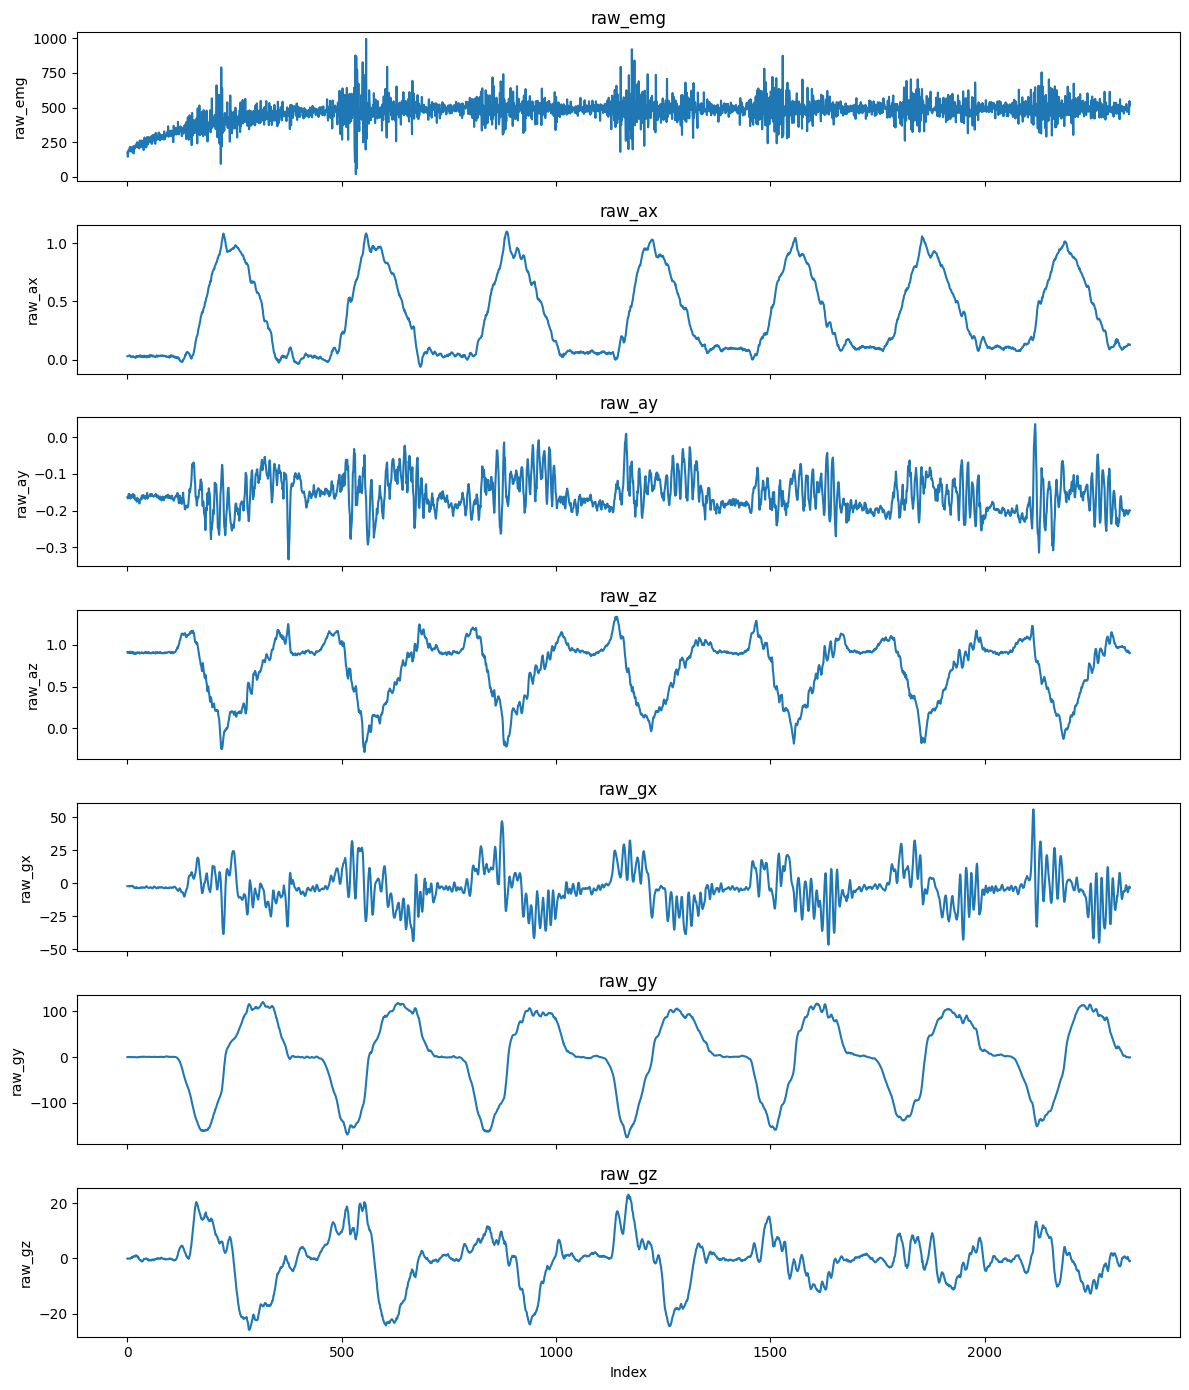

In [119]:
fig, axs = plt.subplots(data.shape[1], 1, figsize=(12, 2 * data.shape[1]), sharex=True)
for i, col in enumerate(data.columns):
    axs[i].plot(data.index, data[col])
    axs[i].set_ylabel(col)
    axs[i].set_title(col)
plt.xlabel('Index')
plt.tight_layout()
plt.show()

In [120]:
raw_emg3 = data['raw_emg'].values

### EMG Filtering

In [121]:
emg_highpass3 = highpass_filter(raw_emg3, cutoff=70, fs=fs)

emg_bandpass3 = bandpass_filter(emg_highpass3, low=20, high=300, fs=fs)

emg_notch3 = notch_filter(emg_bandpass3, fs=fs)

### Filtered EMG plot

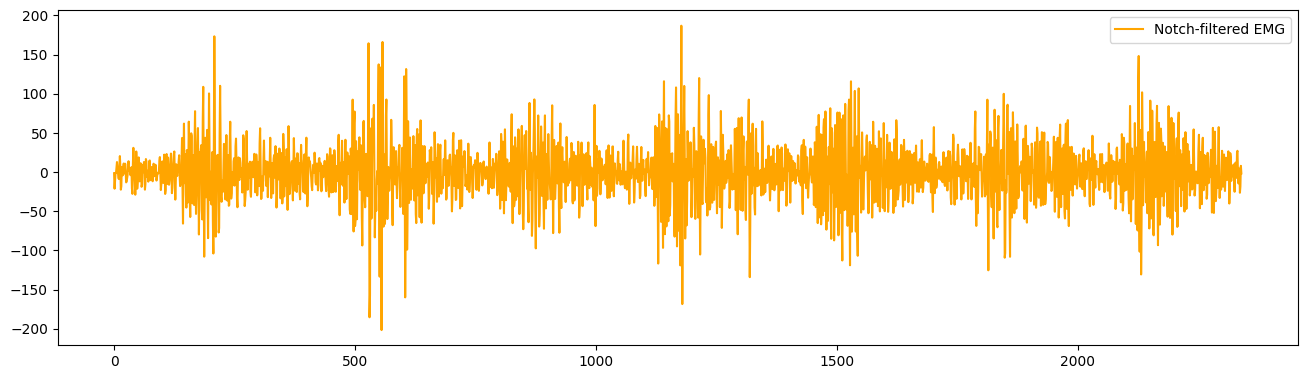

In [122]:
plt.figure(figsize=(16, 20))
# plt.subplot(4, 1, 1)
# plt.plot(raw_emg3, label='Raw EMG', color='blue')
# plt.legend()


plt.subplot(4, 1, 2)
plt.plot(emg_notch3, label='Notch-filtered EMG', color='orange')
plt.legend()

### New dataFrame creation

In [123]:
data3_filtered = pd.DataFrame({
    'raw_emg': raw_emg3,
    'filtered_emg': emg_notch3
})

In [124]:
data3_filtered.to_csv(f'./{filename}/{part}/csv/{filename+num}.csv', index=False)

## Segmentation code

In [125]:
# --- 1. Find positive maxima only ---
positive_peaks, _ = signal.find_peaks(emg_notch3, distance=150)  # only positive peaks

# --- 2. Select top 7 positive peaks by amplitude ---
top_peaks = sorted(positive_peaks, key=lambda x: emg_notch3[x], reverse=True)[:7]
top_peaks.sort()  # sort by position for segmentation

# --- 3. Define boundaries as midpoints between peaks ---
boundaries = [0]
for i in range(len(top_peaks) - 1):
    midpoint = (top_peaks[i] + top_peaks[i + 1]) // 2
    boundaries.append(midpoint)
boundaries.append(len(emg_notch3))  # end of signal

# --- 4. Segment the signal based on boundaries ---
segments = []
for i in range(len(boundaries) - 1):
    start = boundaries[i]
    end = boundaries[i + 1]
    segments.append(data3_filtered.iloc[start:end].copy())

## Segment plotting

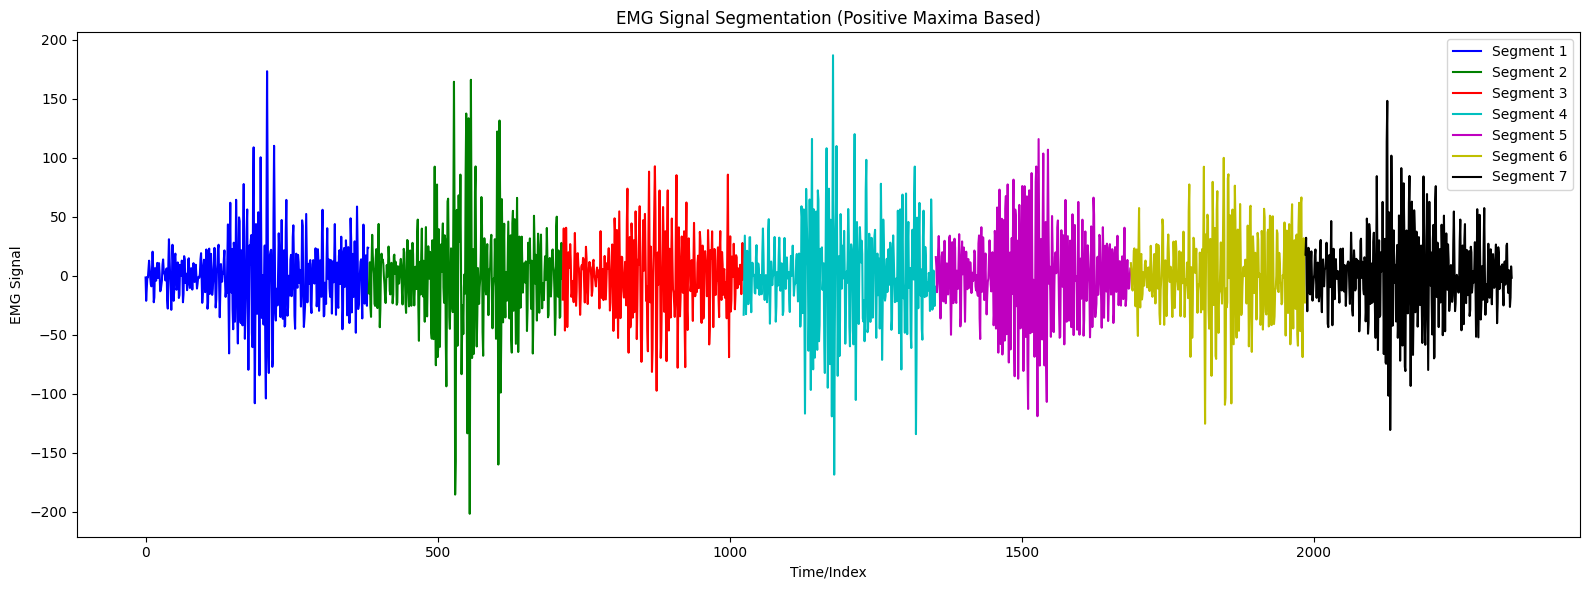

In [126]:
# --- 5. Plot segmented signal (continuous view) ---
plt.figure(figsize=(16, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, seg in enumerate(segments):
    plt.plot(seg.index, seg['filtered_emg'], label=f'Segment {i+1}', color=colors[i % len(colors)])

plt.xlabel('Time/Index')
plt.ylabel('EMG Signal')
plt.title('EMG Signal Segmentation (Positive Maxima Based)')
plt.legend()
plt.tight_layout()
plt.show()

# Not official yet

Smoothening the EMG signal. Not necessary to decide the quality of EMG data

In [127]:
from scipy.signal import savgol_filter
window = 15  # Must be odd
poly_order = 3
emg_smoothed = savgol_filter(emg_notch3, window, poly_order, axis=0)

In [128]:
print(emg_notch3.shape, data.shape, emg_smoothed.shape)

(2340,) (2340, 7) (2340,)


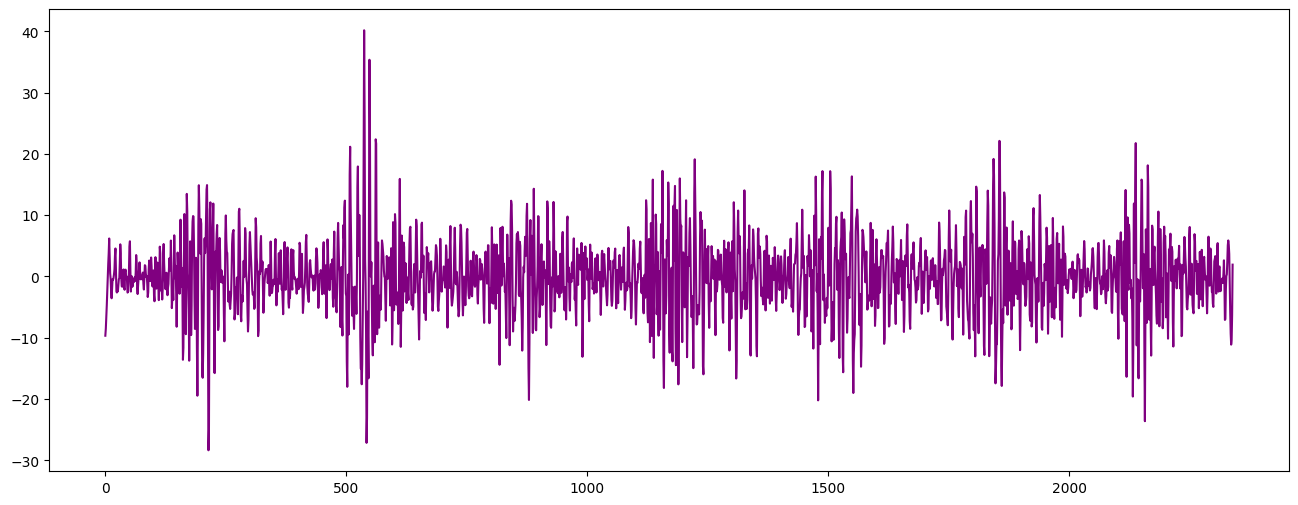

In [129]:
plt.figure(figsize=(16, 6))
plt.plot(emg_smoothed, label='Savitzky-Golay Smoothed EMG', color='purple')

# IMU filtering and smoothing

In [130]:
accel = data[['raw_ax', 'raw_ay', 'raw_az']].values
gyro = data[['raw_gx', 'raw_gy', 'raw_gz']].values

In [131]:
from scipy.signal import butter, filtfilt

def lowpass_filter(data, cutoff_freq, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

# Sample rate (Hz) and cutoff frequency (e.g., 5 Hz for slow movements)
fs = 1000  # Adjust based on your sampling rate
cutoff = 5
accel_filtered = lowpass_filter(accel, cutoff, fs)
gyro_filtered = lowpass_filter(gyro, cutoff, fs)

In [132]:
window_size = 5  # Adjust based on noise level
accel_smooth = pd.DataFrame(accel).rolling(window=window_size, center=True, min_periods=1).mean().values

In [133]:
window_size = 5  # Adjust based on noise level
gyro_smooth = pd.DataFrame(gyro).rolling(window=window_size, center=True, min_periods=1).mean().values

In [134]:
gravity = np.mean(accel_filtered[:, 2])  # Assuming z-axis is vertical
accel_dynamic = accel_filtered.copy()
accel_dynamic[:, 2] -= gravity  # Subtract gravity from the vertical axis

In [135]:
from scipy.signal import savgol_filter
window = 15  # Must be odd
poly_order = 3
accel_smoothed = savgol_filter(accel_filtered, window, poly_order, axis=0)

In [136]:
from scipy.signal import savgol_filter
window = 15  # Must be odd
poly_order = 3
gyro_smoothed = savgol_filter(gyro_filtered, window, poly_order, axis=0)

In [137]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [138]:
for i, seg in enumerate(segments):
    seg_copy = seg.copy()
    seg_copy.insert(0, 'Participant ID', 0)
    seg_copy.insert(1, 'File ID', int(num))
    seg_copy.insert(2, 'Segment ID', i)
    seg_copy.insert(3, 'Segment UID', f'{filename}_{num}_{i}')
    seg_copy.insert(4, 'Segment Start Time', seg.index[0])
    seg_copy.insert(5, 'Segment End Time', seg.index[-1])
    seg_copy.insert(8, 'accel_x', accel[seg.index, 0])
    seg_copy.insert(9, 'accel_y', accel[seg.index, 1])
    seg_copy.insert(10, 'accel_z', accel[seg.index, 2])
    seg_copy.insert(11, 'accel_x_filtered', accel_filtered[seg.index, 0])
    seg_copy.insert(12, 'accel_y_filtered', accel_filtered[seg.index, 1])
    seg_copy.insert(13, 'accel_z_filtered', accel_filtered[seg.index, 2])
    seg_copy.insert(14, 'accel_x_smooth', accel_smooth[seg.index, 0])
    seg_copy.insert(15, 'accel_y_smooth', accel_smooth[seg.index, 1])
    seg_copy.insert(16, 'accel_z_smooth', accel_smooth[seg.index, 2])
    seg_copy.insert(17, 'accel_x_SavGol', accel_smoothed[seg.index, 0])
    seg_copy.insert(18, 'accel_y_SavGol', accel_smoothed[seg.index, 1])
    seg_copy.insert(19, 'accel_z_SavGol', accel_smoothed[seg.index, 2])
    seg_copy.insert(20, 'gyro_x', gyro[seg.index, 0])
    seg_copy.insert(21, 'gyro_y', gyro[seg.index, 1])
    seg_copy.insert(22, 'gyro_z', gyro[seg.index, 2])
    seg_copy.insert(23, 'gyro_x_filtered', gyro_filtered[seg.index, 0])
    seg_copy.insert(24, 'gyro_y_filtered', gyro_filtered[seg.index, 1])
    seg_copy.insert(25, 'gyro_z_filtered', gyro_filtered[seg.index, 2])
    seg_copy.insert(26, 'gyro_x_smooth', gyro_smooth[seg.index, 0])
    seg_copy.insert(27, 'gyro_y_smooth', gyro_smooth[seg.index, 1])
    seg_copy.insert(28, 'gyro_z_smooth', gyro_smooth[seg.index, 2])
    seg_copy.insert(29, 'gyro_x_SavGol', gyro_smoothed[seg.index, 0])
    seg_copy.insert(30, 'gyro_y_SavGol', gyro_smoothed[seg.index, 1])
    seg_copy.insert(31, 'gyro_z_SavGol', gyro_smoothed[seg.index, 2])
    seg_copy.insert(32, 'body_position', part)
    master_csv = pd.concat([master_csv, seg_copy], ignore_index=True)



In [139]:
master_csv

,Participant ID,File ID,Segment ID,Segment UID,Segment Start Time,Segment End Time,raw_emg,filtered_emg,accel_x,accel_y,...,gyro_x_filtered,gyro_y_filtered,gyro_z_filtered,gyro_x_smooth,gyro_y_smooth,gyro_z_smooth,gyro_x_SavGol,gyro_y_SavGol,gyro_z_SavGol,body_position
0,0,1,0,hemanth_1_0,0,297,236.0,-0.082192,0.1123,-0.2063,...,-2.853819,12.594293,1.049472,-4.18830,-0.715033,0.106833,-2.853830,12.594094,1.049472,Bicep
1,0,1,0,hemanth_1_0,0,297,88.0,-99.899272,0.1143,-0.2017,...,-2.861167,12.339640,1.052301,-4.15840,-0.704225,0.005700,-2.861163,12.339723,1.052301,Bicep
2,0,1,0,hemanth_1_0,0,297,175.0,-37.220698,0.1104,-0.2117,...,-2.869808,12.062731,1.054644,-3.98168,-0.647340,-0.058040,-2.869798,12.062904,1.054644,Bicep
3,0,1,0,hemanth_1_0,0,297,246.0,12.810306,0.1104,-0.2063,...,-2.879767,11.763223,1.056480,-3.76642,-0.600000,-0.259560,-2.879758,11.763366,1.056480,Bicep
4,0,1,0,hemanth_1_0,0,297,101.0,-20.782211,0.1182,-0.2014,...,-2.891066,11.440785,1.057791,-3.39848,-0.679380,-0.430540,-2.891063,11.440839,1.057792,Bicep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6368,0,3,6,hemanth_3_6,1986,2339,501.0,0.581961,0.1340,-0.2070,...,-14.390250,105.611793,-6.684639,-5.28854,-0.516020,-0.126720,-14.390246,105.611775,-6.684639,Bicep
6369,0,3,6,hemanth_3_6,1986,2339,488.0,-26.351314,0.1257,-0.2073,...,-14.390534,105.611134,-6.684517,-4.71450,-0.685480,-0.355720,-14.390522,105.611093,-6.684516,Bicep
6370,0,3,6,hemanth_3_6,1986,2339,452.0,-18.393876,0.1248,-0.2002,...,-14.390761,105.610562,-6.684416,-4.03358,-0.789300,-0.683960,-14.390747,105.610514,-6.684415,Bicep
6371,0,3,6,hemanth_3_6,1986,2339,547.0,8.007990,0.1287,-0.1980,...,-14.390941,105.610072,-6.684333,-3.50190,-0.952275,-0.849225,-14.390934,105.610051,-6.684332,Bicep


In [146]:
master_csv.to_csv('hemanth_test_bicep.csv', index=False)

In [141]:
master_csv.columns

Index(['Participant ID', 'File ID', 'Segment ID', 'Segment UID',
       'Segment Start Time', 'Segment End Time', 'raw_emg', 'filtered_emg',
       'accel_x', 'accel_y', 'accel_z', 'accel_x_filtered', 'accel_y_filtered',
       'accel_z_filtered', 'accel_x_smooth', 'accel_y_smooth',
       'accel_z_smooth', 'accel_x_SavGol', 'accel_y_SavGol', 'accel_z_SavGol',
       'gyro_x', 'gyro_y', 'gyro_z', 'gyro_x_filtered', 'gyro_y_filtered',
       'gyro_z_filtered', 'gyro_x_smooth', 'gyro_y_smooth', 'gyro_z_smooth',
       'gyro_x_SavGol', 'gyro_y_SavGol', 'gyro_z_SavGol', 'body_position'],
      dtype='object')

In [142]:
# df1 = pd.read_csv('Datasets/master_csv_bicep_0.csv')
# df2 = pd.read_csv('Datasets/master_csv_tricep_0.csv')

In [143]:
# master_csv = pd.concat([df1, df2], ignore_index=True)
# master_csv.to_csv('master_csv_0.csv', index=False)

In [144]:
# df1 = pd.read_csv('Datasets/master_csv_bicep_0.csv')
# df2 = pd.read_csv('Datasets/master_csv_tricep_0.csv')
# df3 = pd.read_csv('Datasets/master_csv_Supination_1.csv')
# df4 = pd.read_csv('Datasets/master_csv_Pronation_1.csv')

In [145]:
# master_csv = pd.concat([df1, df2, df3, df4], ignore_index=True)
# master_csv.to_csv('Datasets/master_csv_0.csv', index=False)